# HW3_3 - Linear classification - Solutions

Prof. Dimitrios Milioris

Learning contents:
* Least squares for classification
* Perceptron
* Logistic regression
* Extra: multi-class logistic regression

In [1]:
# Dependencies
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set() # this import just makes the plots prettier
import numpy as np

## Data
We'll be working with a dataset of handwritten digits. 
Let visualise some examples.

In [2]:
# We're using a subset of two classes for now
digits = load_digits(n_class=2)

In [3]:
# Handy plotting functions
x_min, x_max = -40, 40
y_min, y_max = -40, 40

def plot_examples():
    show_num = 4
    _, axes = plt.subplots(1, show_num)
    images_and_labels = list(zip(digits.images, digits.target))
    for ax, (image, label) in zip(axes[:], images_and_labels[:show_num]):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        ax.set_title('Label: %i' % label)

def plot_scatter(data, target, n_class=2, alpha=0.5):
    scatter = plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=alpha, cmap=plt.cm.get_cmap('rainbow', n_class))
    plt.legend(*scatter.legend_elements(), loc="upper left", title="Targets")
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

def plot_decision_boundary(data, weights):
    weights = weights.flatten()
    intersection = weights[0]
    slope = - weights[1] / weights[2]
    xx = np.linspace(x_min, x_max)
    yy = slope * xx - intersection
    plt.plot(xx, yy, 'k--')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

def plot_mesh(X, pred_fn, n_class=2):
    h = 0.1  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_fn(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))
    plt.axis('tight')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)


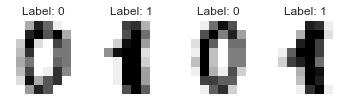

In [4]:
plot_examples()

In [5]:
# The dataset contains 2D data in the form of the `images` attribute, 
# as well as a 1D-version called `data`, where the images have been flattened. 
np.array_equal(digits.images[0].flatten(), digits.data[0])

True

In [6]:
# We can get a 2D version of the data using PCA
pca = PCA(n_components=2)
X = pca.fit_transform(digits.data) # this is the representation, we'll be working with

In [7]:
# Out targets are in the set {0,1}
t_01 = digits.target

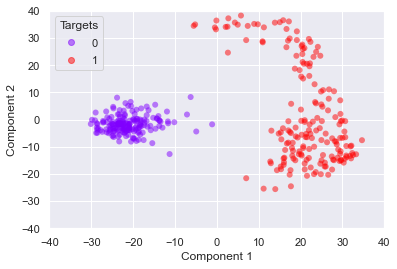

In [8]:
# Let's plot all the data in 2D
plot_scatter(X, t_01)

## 1) Least Squares

### 1.1) Find the weight vector using Least Squares for classification
Hint: Remember to augment the data with a column of 1's

In [9]:
# Augment X with ones
def augment(X):
    """ Augment with bias component: phi_0(x) = 1 """
    return np.hstack((np.ones((len(X),1)), X))

X_tilde = augment(X)

In [10]:
# Check an example
X_tilde[0]

array([  1.        , -24.84615349,  -0.89358165])

In [11]:
# Compute the weights
W_tilde = np.linalg.pinv(X_tilde) @ t_01
W_tilde = np.expand_dims(W_tilde,axis=0)
W_tilde

array([[0.50555556, 0.02182423, 0.00478603]])

### 1.2) Create class predictions using the weight vector
You should be able to correctly classify all data

In [12]:
def predict(W_tilde, X_tilde, boundary=0.5):
    y = (W_tilde @ X_tilde.T)[0] #[0] is used to unpack the vector
    preds = np.array(y > boundary, dtype=int)
    return preds

In [13]:
preds = predict(W_tilde, X_tilde)

In [14]:
np.array_equal(t_01, preds)

True

### 1.3) Plot the decision boundary 
Hint: You can do this either by plotting a line on the boundary or creating a mesh of all predictions

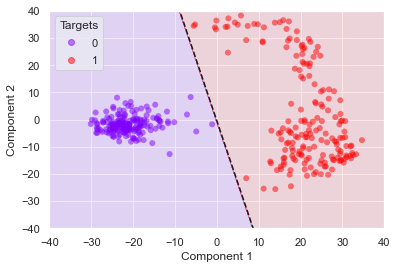

In [15]:
plot_scatter(X, preds)
plot_decision_boundary(X, W_tilde)
plot_mesh(X, lambda x: predict(W_tilde, augment(x)), n_class=2)

## 2) Perceptron

A learning_rate of 0.1 should do the job.
Hint: remember to change the target representation range

In [16]:
learning_rate = 0.1

def phi(X):
    """ Augment with bias component: phi_0(x) = 1 and squared values """
    return np.hstack((np.ones((len(X),1)), X, X**2))

def f(a):
    o = np.ones_like(a)
    return o*(a>0) - o*(a<0)

def predict(W_tilde, X_tilde, boundary=0.5):
    y = f((W_tilde @ X_tilde.T)[0]) #[0] is used to unpack the vector
    preds = np.array(y > boundary, dtype=int)
    return preds

# Our data is already shuffled, so skip that step
X_train = phi(X)

# Our target vectors should be {-1, 1}
t_11 = 2 * digits.target - 1

W_0 = [[ 0.55540482 -0.52491756  0.64855707  0.9314984   0.94520223]]


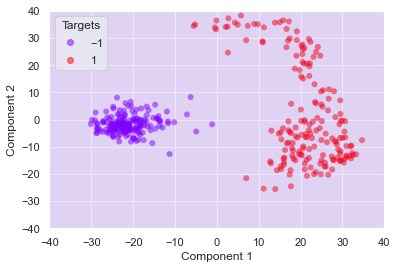

In [17]:
# Initial weight vector
np.random.seed(13)
W_0 = 2 * np.random.random((1, X_train.shape[1])) -1 # random values in the range [-1,1]
print("W_0 = {}".format(W_0))

plot_scatter(X, t_11)
plot_mesh(X, lambda x: predict(W_0, phi(x)), n_class=2)

In [18]:
def misclassified(W, X, t):
    return W @ X.T * t <= 0

def weight_update(W, X, t):
    M = misclassified(W[0], X, t)
    M = np.broadcast_to(np.expand_dims(M,axis=1), X.shape)
    t = np.broadcast_to(np.expand_dims(t,axis=1), X.shape)
    zeros = np.zeros_like(X)
    return np.sum(np.where(M, X*t, zeros), axis=0)

In [19]:
epoch = 0
W_per = [W_0]

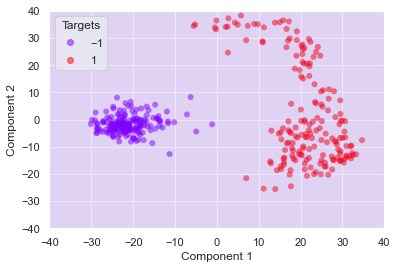

In [20]:
# Do a few updates manually and check progress

# Apply update
W_per.append(W_per[epoch] + learning_rate * weight_update(W_per[epoch], X_train, t_11))

# Plot updates weight
plot_scatter(X, t_11)
plot_mesh(X, lambda x: predict(W_per[epoch+1], phi(x)), n_class=2)

epoch += 1

In [21]:
# Do rest of the updates
for e in range(epoch, 1000):
    W_per.append(W_per[epoch] + learning_rate * weight_update(W_per[epoch], X_train, t_11))
    epoch += 1

W_perceptron = W_per[-1]

### 2.2) Perform class-predictions
Again, you should be able to classify all correctly

In [22]:
preds = 2 * predict(W_perceptron, X_train) - 1
np.array_equal(preds, t_11)

True

### 2.3) Plot the decision boundary

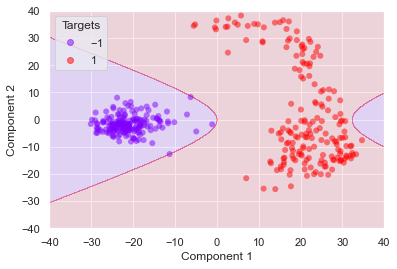

In [23]:
plot_scatter(X, preds)
plot_mesh(X, lambda x: predict(W_perceptron, phi(x)), n_class=2)

## 3) Logistic Regression
### 3.1) Find the weight vector using the Logistic Regression

In [24]:
X_train = augment(X)

# initialise W_0 randomly
np.random.seed(42)
W_0 = 2 * np.random.random((1, X_train.shape[1])) -1 # random values in the range [-1,1]

# Our target vectors should be {0, 1}
t = digits.target

In [25]:
def sigmoid(a):
    return 1/ (1 + np.exp(-a))

def error(W, X, t):
    y = sigmoid(W @ X.T).flatten()
    yt = (y - t)
    yt = np.broadcast_to(np.expand_dims(yt,axis=1), X.shape)
    return np.sum(yt*X, axis=0)/len(t)

In [26]:
W_log = [W_0]
for epoch in range(30):
    W_log.append(W_log[epoch] - learning_rate * error(W_log[epoch], X_train, t))

W_logistic = W_log[-1]

### 3.2) Perform class-predictions

In [27]:
preds = predict(W_logistic, X_train)
np.array_equal(preds, t)

True

### 3.3) Plot the decision boundary

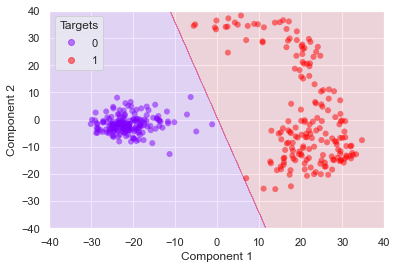

In [28]:
plot_scatter(X, preds)
plot_mesh(X, lambda x: predict(W_logistic, augment(x)), n_class=2)

## 4) Multi-class logistic regression
Repeat 3) but now for multiple classes, i.e. compute the weight matrix, perform predictions (you shold be able to get about 93% accuracy) and plot decision boundaries.

Hint: You will need to use a one-hot encoding of the targets

In [29]:
# Data
n_class = 3
digits = load_digits(n_class=n_class)
pca = PCA(n_components=2)
X_mult = pca.fit_transform(digits.data)

learning_rate = 0.1

In [30]:
X_train_mult = augment(X_mult)

# We need to do a one_hot encoding of our data: 1 -> [0,1,0], 2 -> [0,0,1]
def one_hot(targets, n_class=n_class):
    res = np.eye(n_class)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[n_class])

t_cat = digits.target
t_oh = one_hot(digits.target, n_class)

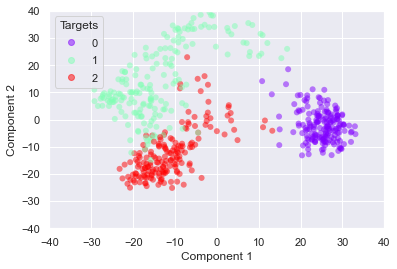

In [31]:
plot_scatter(X_mult, t_cat, n_class=n_class)

In [32]:
def softmax(x):
    e = np.exp(x - np.max(x))  # prevent overflow
    return e / np.maximum(np.sum(e, axis=0), 1e-16) # prevent divide by zero

def grad_error(W, X, t):
    y = softmax(W @ X.T).T
    yt = (y - t_oh)
    yt_wide = np.repeat(yt, X.shape[1],1)
    X_wide = np.tile(X, (1, yt.shape[1]))
    return np.sum(yt_wide*X_wide, axis=0).reshape(W.shape) / X.shape[0]

def predict(W, X):
    y = softmax(W @ X.T).T
    return np.argmax(y, axis=1)

def accuracy(preds, targets):
    return np.sum(preds == targets) / len(targets)

In [33]:
# Weight initialisation
np.random.seed(25)
W_0 = 2 * np.random.random((n_class, X_train_mult.shape[1])) - 1
W_log_mult = [W_0]
epoch = 0

epoch = 0
acc =  0.40037243947858475


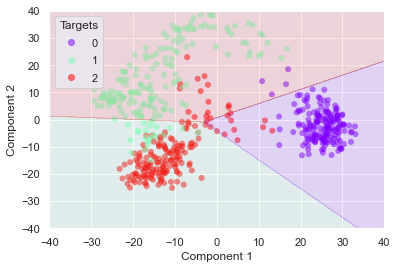

In [34]:
# Print metrics
print("epoch = {}".format(epoch))
# print("weight =  {}".format(W_log_mult[epoch]))
preds = predict(W_log_mult[epoch], X_train_mult)
print("acc =  {}".format(accuracy(preds, t_cat)))

# Plot updates weight
plot_scatter(X_mult, t_cat, n_class=n_class)
plot_mesh(X_mult, lambda x: predict(W_log_mult[epoch], augment(x)), n_class=n_class)

In [35]:
W_log_mult = [W_0]
for epoch in range(50):
    W_log_mult.append(W_log_mult[epoch] - learning_rate * grad_error(W_log_mult[epoch], X_train_mult, t_oh))

W_multi_logistic = W_log_mult[-1]

epoch = 49
acc =  0.931098696461825


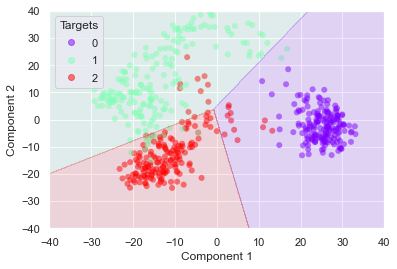

In [36]:
# Print metrics
print("epoch = {}".format(epoch))
# print("weight =  {}".format(W_log_mult[epoch]))
preds = predict(W_log_mult[epoch], X_train_mult)
print("acc =  {}".format(accuracy(preds, t_cat)))

# Plot updates weight
plot_scatter(X_mult, t_cat, n_class=n_class)
plot_mesh(X_mult, lambda x: predict(W_log_mult[epoch], augment(x)), n_class=n_class)

## 5) Multi-class logistic regression on original data representation
Repeat exercise 4), but use the original data representation instead.
You can omit the plots.

Hint: To get 100% accuracy, you can try to:
- Rescale your data to the range [0,1]
- Run 1000 epochs with learning_rate = 0.1

In [37]:
X_train_mult_orig = phi(digits.data / digits.data.max()) 
X_train_mult_orig.shape #64 + 1 dimensions

(537, 129)

In [38]:
# Weight initialisation
np.random.seed(25)
W_0 = 2 * np.random.random((n_class, X_train_mult_orig.shape[1])) - 1
W_0.shape

(3, 129)

In [39]:
W_log_mult_orig = [W_0]
for epoch in range(1000):
    W_log_mult_orig.append(W_log_mult_orig[epoch] - learning_rate * grad_error(W_log_mult_orig[epoch], X_train_mult_orig, t_oh))

W_mult_logistic_orig = W_log_mult_orig[-1]

In [40]:
preds = predict(W_mult_logistic_orig, X_train_mult_orig)
print("acc =  {}".format(accuracy(preds, t_cat)))

acc =  1.0
